In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.rcParams['figure.figsize'] = (12,6)

In [2]:
df = pd.read_csv("Data/ECA_blended_custom/TG_STAID002759.txt", skiprows= 18, sep=',')

In [3]:
df.columns = ['SOUID', 'DATE','TG','Q_TG']

In [4]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day


SOUID    0
DATE     0
TG       0
Q_TG     0
year     0
month    0
day      0
dtype: int64

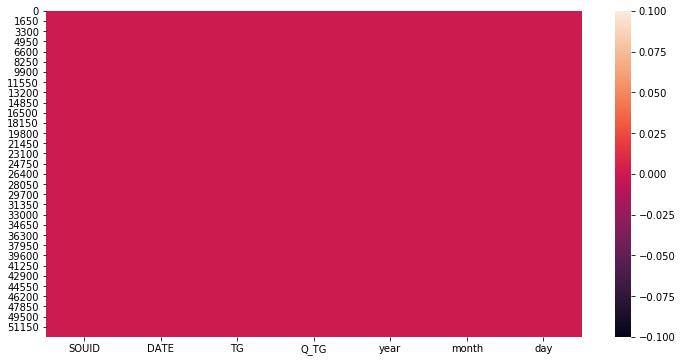

In [5]:
sns.heatmap(df.isna())
df.isna().sum()

In [6]:
df.set_index('DATE', inplace = True)

In [7]:
df['Celsius'] = df['TG'] * 0.1
df['Kelvin'] = df['Celsius'] + 273.15 

In [8]:
df['differences'] = df.Kelvin.diff()
df['pct_change'] = df.Kelvin.pct_change()

In [9]:
df.head()

,SOUID,TG,Q_TG,year,month,day,Celsius,Kelvin,differences,pct_change
DATE,,,,,,,,,,
1876-01-01,127488,22,0,1876,1,1,2.2,275.35,NaN,NaN
1876-01-02,127488,25,0,1876,1,2,2.5,275.65,0.3,0.001090
1876-01-03,127488,3,0,1876,1,3,0.3,273.45,-2.2,-0.007981
1876-01-04,127488,-58,0,1876,1,4,-5.8,267.35,-6.1,-0.022308
1876-01-05,127488,-98,0,1876,1,5,-9.8,263.35,-4.0,-0.014962


In [10]:
#df['seasonal_mean'] = df['pct_change'].groupby(df['month']).transform('mean')
#df['deseasonalized'] = df['pct_change'] - df['seasonal_mean']

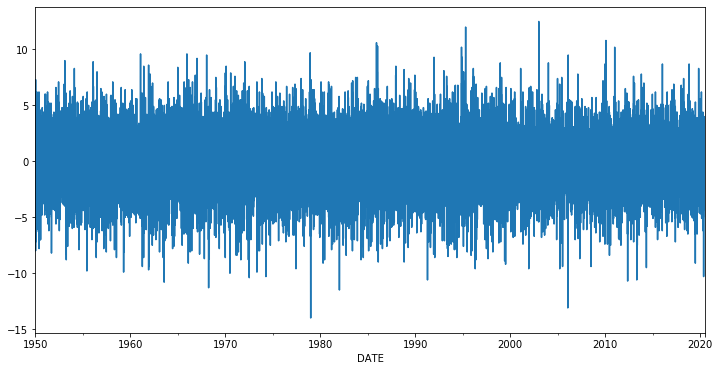

In [11]:
df.Celsius['1950':].diff().plot()

## Train-test split

In [12]:
df_clean = df['1950':]
df_train = df['1950':'2019']
df_test = df['2019':]

In [13]:
df_test['y_pred_mean'] = df_train['Kelvin'].mean()
df_test['y_pred_mean_pct_change'] = df_train['pct_change'].mean()
df_test['y_pred_mean_pct_change'] += 1
df_test['y_pred_mean_pct_change'] = np.cumprod(df_test['y_pred_mean_pct_change'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [14]:
df_train.groupby('month')['pct_change'].mean()

month
1     0.000019
2     0.000358
3     0.000593
4     0.000633
5     0.000447
6     0.000317
7     0.000245
8    -0.000304
9    -0.000529
10   -0.000580
11   -0.000503
12   -0.000238
Name: pct_change, dtype: float64

In [15]:
# Take the last actual observation as starting point
last_observation = df_train['Kelvin'][-1]

df_test['y_pred_mean_pct_change'] *= last_observation


df_test.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,SOUID,TG,Q_TG,year,month,day,Celsius,Kelvin,differences,pct_change,seasonal_mean,deseasonalized,y_pred_mean,y_pred_mean_pct_change
DATE,,,,,,,,,,,,,,
2019-01-01,111448,66,0,2019,1,1,6.6,279.75,0.8,0.002868,0.000027,0.002841,282.971626,279.160143
2019-01-02,111448,18,0,2019,1,2,1.8,274.95,-4.8,-0.017158,0.000027,-0.017185,282.971626,279.170286
2019-01-03,111448,-3,0,2019,1,3,-0.3,272.85,-2.1,-0.007638,0.000027,-0.007664,282.971626,279.180430
2019-01-04,111448,21,0,2019,1,4,2.1,275.25,2.4,0.008796,0.000027,0.008769,282.971626,279.190574
2019-01-05,111448,61,0,2019,1,5,6.1,279.25,4.0,0.014532,0.000027,0.014506,282.971626,279.200719


In [16]:
# Define a function that plots the forecast for us
def plot_forecast(y_train, y_test, columns):
    '''
    Plots forecasts of passenger data
    
    Params:
    -------
    y_train: The training data
    y_test: The test data
    columns: Name of the prediction columns form a DataFrame
    
    '''
    # Plot the actual values
    y_train.Kelvin[-1000:].plot(label='Training Data')
    y_test.Kelvin[-1000:].plot(label=('Test Data'))
    
    # Plot each prediction
    for column in columns:
        y_test[column].plot(label=column)
    
    # General settings
    #plt.title('Nr. of Passengers per Month over Time', fontsize=15)
    #plt.ylabel('Nr. of Passengers', fontsize=12)
    #plt.xlabel('Date', fontsize=12)
    #plt.legend()
    # plt.savefig('mean_baseline.png')
    #plt.show()

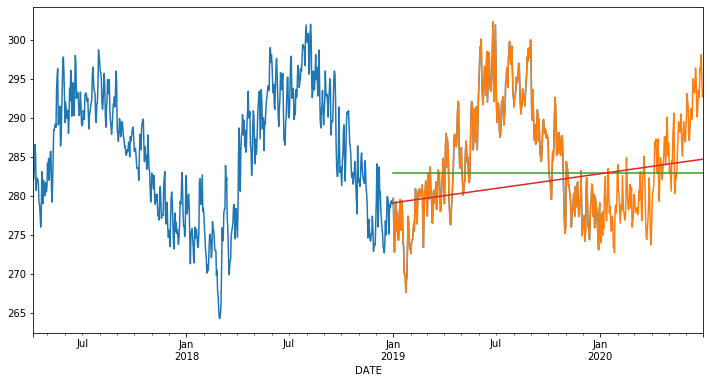

In [17]:
# Plot the forecast
plot_forecast(df_train, df_test, ['y_pred_mean', 'y_pred_mean_pct_change'])

In [18]:
df_train.groupby('month')['pct_change'].mean()

month
1     0.000019
2     0.000358
3     0.000593
4     0.000633
5     0.000447
6     0.000317
7     0.000245
8    -0.000304
9    -0.000529
10   -0.000580
11   -0.000503
12   -0.000238
Name: pct_change, dtype: float64

In [23]:
df_train['monthly_means'] = df_train.groupby('month')['pct_change'].transform("mean")
df_train.tail()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SOUID,TG,Q_TG,year,month,day,Celsius,Kelvin,differences,pct_change,seasonal_mean,deseasonalized,monthly_means
DATE,,,,,,,,,,,,,
2019-12-27,111448,31,0,2019,12,27,3.1,276.25,-1.8,-0.006474,-0.000248,-0.006226,-0.000238
2019-12-28,111448,13,0,2019,12,28,1.3,274.45,-1.8,-0.006516,-0.000248,-0.006268,-0.000238
2019-12-29,111448,0,0,2019,12,29,0.0,273.15,-1.3,-0.004737,-0.000248,-0.004489,-0.000238
2019-12-30,111448,45,0,2019,12,30,4.5,277.65,4.5,0.016474,-0.000248,0.016722,-0.000238
2019-12-31,111448,60,0,2019,12,31,6.0,279.15,1.5,0.005402,-0.000248,0.005650,-0.000238


In [35]:
size = df_test.size
df_train['monthly_means']['2016':'30-06-2017'].index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
               '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30'],
              dtype='datetime64[ns]', name='DATE', length=547, freq=None)

In [33]:
df_test.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='DATE', length=547, freq=None)

In [37]:
df_test['monthly_means'] = df_train['monthly_means']['2016':'30-06-2017'].values
df_test.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SOUID,TG,Q_TG,year,month,day,Celsius,Kelvin,differences,pct_change,seasonal_mean,deseasonalized,y_pred_mean,y_pred_mean_pct_change,monthly_means
DATE,,,,,,,,,,,,,,,
2019-01-01,111448,66,0,2019,1,1,6.6,279.75,0.8,0.002868,0.000027,0.002841,282.971626,279.160143,0.000019
2019-01-02,111448,18,0,2019,1,2,1.8,274.95,-4.8,-0.017158,0.000027,-0.017185,282.971626,279.170286,0.000019
2019-01-03,111448,-3,0,2019,1,3,-0.3,272.85,-2.1,-0.007638,0.000027,-0.007664,282.971626,279.180430,0.000019
2019-01-04,111448,21,0,2019,1,4,2.1,275.25,2.4,0.008796,0.000027,0.008769,282.971626,279.190574,0.000019
2019-01-05,111448,61,0,2019,1,5,6.1,279.25,4.0,0.014532,0.000027,0.014506,282.971626,279.200719,0.000019


In [38]:
df_test['y_pred_mm_pct_change']=df_test['monthly_means']+1
df_test['y_pred_mm_pct_change'] = np.cumprod(df_test['y_pred_mm_pct_change'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
df_test['y_pred_mm_pct_change'] *= last_observation
df_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SOUID,TG,Q_TG,year,month,day,Celsius,Kelvin,differences,pct_change,seasonal_mean,deseasonalized,y_pred_mean,y_pred_mean_pct_change,monthly_means,y_pred_mm_pct_change
DATE,,,,,,,,,,,,,,,,
2019-01-01,111448,66,0,2019,1,1,6.6,279.75,0.8,0.002868,0.000027,0.002841,282.971626,279.160143,0.000019,279.155294
2019-01-02,111448,18,0,2019,1,2,1.8,274.95,-4.8,-0.017158,0.000027,-0.017185,282.971626,279.170286,0.000019,279.160588
2019-01-03,111448,-3,0,2019,1,3,-0.3,272.85,-2.1,-0.007638,0.000027,-0.007664,282.971626,279.180430,0.000019,279.165882
2019-01-04,111448,21,0,2019,1,4,2.1,275.25,2.4,0.008796,0.000027,0.008769,282.971626,279.190574,0.000019,279.171177
2019-01-05,111448,61,0,2019,1,5,6.1,279.25,4.0,0.014532,0.000027,0.014506,282.971626,279.200719,0.000019,279.176471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,111448,226,0,2020,6,26,22.6,295.75,-0.8,-0.002698,0.000268,-0.002966,282.971626,284.712262,0.000317,303.478670
2020-06-27,111448,250,0,2020,6,27,25.0,298.15,2.4,0.008115,0.000268,0.007847,282.971626,284.722608,0.000317,303.574876
2020-06-28,111448,224,0,2020,6,28,22.4,295.55,-2.6,-0.008720,0.000268,-0.008989,282.971626,284.732953,0.000317,303.671112


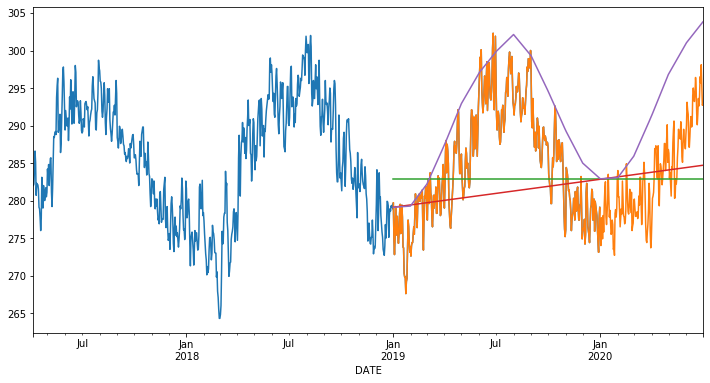

In [41]:
plot_forecast(df_train, df_test, ['y_pred_mean', 'y_pred_mean_pct_change', 'y_pred_mm_pct_change'])

In [45]:
df_test['y_pred_persistence'] = df_test['Kelvin'].shift(30)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


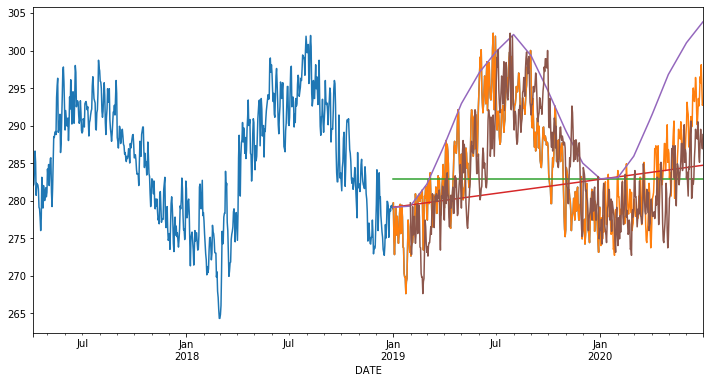

In [46]:
plot_forecast(df_train, df_test, ['y_pred_mean', 'y_pred_mean_pct_change', 'y_pred_mm_pct_change', 'y_pred_persistence'])